# Predictions of fraudlent users in a Bitcoin user network #

On platforms where users interact with each other to perform some type of financial transaction, it is very desirable to stop users who act in a fraudulent manner from being able to access or continue to use the platform. However, investigating users can be very expensive (consider e.g sellers on Ebay or Amazon) or impossible (consider users on a Bitcoin network) depending on the context. It is therefore worth asking the following - is it possible to perform accurate inference for the trustworthiness of users simply based on their behavior on the platform? We investigate this using publically available data for a Bitcoin user platform, where we observe ratings between users (and the times at which these ratings are made), and only know for a small subset of users whether they are trustworthy or not. 

In [37]:
### DEMO - switch to True if you want to check whether the code works, rather than
### spend forever running the code. Note: if you don't change this, then some of 
### the plots will probably get overwritten, which are saved and then imported into
### the notebook. demo = False corresponds to code written to generate the plots
### displayed here.
demo = False

## Summary of data ## 

For the dataset we are considering, we have 5,881 nodes (corresponding to separate users) and 35,592 weighted edges (corresponding to ratings from one user to another), along with time-stamp data; for example, a subset of the data looks like the following:

Source node | Target node | Rating | Time stamp
:----------:|:-----------:|:------:|:---------:
6 | 2 |	4 | 1289241912
6 | 5 | 2 | 1289241942
1 | 15 | 1 | 1289243140
4 | 3 | 7 | 1289245277
13 | 16 | 8 | 1289254254
13 | 10 | 8 | 1289254301
7 | 5 | 1 | 1289362700
2 | 21 | 5 | 1289370557

We note that ratings are integer valued between -10 to 10 (going from not-trustworthy to trustworthy) - when we analyse the data, we will normalize these to lie in [0, 1], and we will ignore the fact that user ratings are given on an integer scale. This is done mostly for computational reasons, as it will be more convenient to model ratings given by users on a continuous scale rather than a discrete one. The measurements for the time stamps are given as measurements of the time in seconds after 'Epoch' (January 1st 1970) in which the ratings were made; although we could try and use this information more substanatially (and e.g try and model trustworthiness as a function of time), for now we will only use it to compute per-node summary statistics. 

We also have some notion of "ground truth" data for the users in the network - there are 136 users which are considered trustworthy, and 180 not trustworthy users (so we have ground truth data for 316 users in total). Note that this is only for a subset of the users, so we will use a semi-supervised approach to modelling our data. As our end goal is to make inference for the trustworthiness for users, we will split the ground truth data in half (by randomly selecting indices) to form training and test sets when we are performing semi-supervised or supervised learning. One note: there is likely an imblance in the proportions of trustworthy/non-trustworthy users in the train/test sets, as compared to those in the whole population, and so this is something which we should be aware of when modelling our data.

## A quick caveat on our notion of ground truth ## 

Given that our data is taken from an inherently anonymous platform, you may (rightfully) ask whether the notion of 'ground-truth trustworthiness' comes from. For this dataset, the platform founder and those who they rated highly are considered to be trustworthy, and the users rated very lowly by the latter group are considered to be un-trustworthy. (In terms of the numerical specifics, I'm afraid I don't have those at hand - it's not very clear from the data source what exactly was done to obtain this information.) As a result, this is a clear limitation as to whether these users are actually acting fraudulently or not - instead we are really making inference for whether the platform holder would consider someone to be trustworthy. From e.g the perspective of the platform founder, this probably would suffice. 

## Evaluating model performance ## 

As our overall goal is to make inference for a latent state of each user (namely, whether they are trustworthy or not), the way in which we will evaluate our models will reflect this. In all of our models, we will try and infer for each user a probability of trustworthiness, as this is more informative than inference for the discrete state, and also provides us with more evaluation tools. To evaluate models, we will examine ROC curves and the AOC for labelled data in our training and test splits, along with calibration curves for the test data. Note that this only gives us a way of evaluating the model on a tiny proportion of our actual data set. We therefore will also examine:

* the population distribution of the estimated probabilities of trustworthiness
* posterior predictive checks for certain summary statistics of the network

# Exploratory data analysis

Before beginning to model the data in order to try and make inference for the trustworthiness of different users, we begin by exploring some of the features of our dataset to see what could potentially be informative for the purposes of achieving our overall goal. In particular, we're going to examine the following statistics of the data:

* The in and out degree distribution (i.e, how many ratings a user has received and given respectfully)
* The distribution of the mean and average ratings recived and given by users 
* The standard deviation of the time at which ratings are made
* Rating asymmetry - the difference between the in and out degrees of a node, and simiarly the difference of the average in rating and out rating

For the users whose ground truth state is available, we'll highlight their distribution in blue and orange (corresponding to trustworthy and not-trustworthy respectfully), and otherwise keep the overall distribution in grey.

In [11]:
import warnings
import torch
import logging
import numpy as np

# Used to supress some NumPy warnings when loading data
warnings.simplefilter('ignore', category=RuntimeWarning)

# Printing logging information
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Used to automatically reload imported scripts for debugging
%load_ext autoreload
%autoreload 1

# Import various external scripts with auto-reloading
%aimport eda
%aimport plotfns
%aimport bayes
%aimport bitcoin
%aimport embed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# If you want to verify the output, switch the commenting of the following lines
if demo:
    eda.plot_summary_stat(fname=None, display=True)
else:
    eda.plot_summary_stat(fname='img/summary_stat.png', display=False)

![title](img/summary_stat.png)

Examining the above plots, we see that in terms of node-level information we can use to try and predict whether a user is trustworthy, we observe that there are a few discriminating features we could try and use:

* **The average rating received** - Somewhat unsuprisingly, the average rating received by untrustworthy users is lower than that of trustworthy users, and lies on the left tail of the overall distribution of average ratings. 
* **The standard deviation of ratings given and received** - As observable from the two graphs, large observed values of the standard deviation of the ratings given or received by a user are more likely to come from users who have been deemed non-trustworthy, compared to both the base population and users who are considered trustworthy. For the ratings received, this is not too unsuprising - one can imagine that a collection of conspiring users who are not trustworthy will try and collectively give each other large positive ratings, while other users will give them large negative ratings. However, it is a bit more difficult to try and think of a reason as to why the standard deviation of the ratings given seems to vary across the different population.
* **Standard deviation of rating times** - This appears to be a somewhat weaker form of evidence, but we note that a large proportion of un-trustworthy users are only active for a short period of time, whereas the distribution of trustworthy is more uniform (and similarly so for the overall population of users).

Given this, we'll therefore begin by seeing what happens when using a simple logistic regression on the labelled part of the dataset, using these as features.

# Model 1: A straightforward Bayesian logistic regression

We'll begin by fitting the following Bayesian logistic regression model based off the examination above: we'll suppose that user $i$ has a trustworthy indicator $a_i$ with $a_i = 1$ corresponding to a user being trustworthy and $a_i = 0$ not trustworthy. We'll then suppose that the $a_i$ are independent Bernoulli random variables, whose probability of success $p_i$ conditional on 

* The average rating received $\mathrm{R}_i$, centered to lie within $[-0.5, 0.5]$ (see footnote [a] for more info);
* The standard deviation of ratings given $\mathrm{SDG}_i$ and received $\mathrm{SDR}_i$, rescaled to lie within $[0, 1]$ (see footnote [b] for more info); and
* The standard deviation of rating times $\mathrm{SDT}_i$ given, rescaled to lie within $[0, 1]$ (see footnote [c] for more info),

is given by 

$$ \log\Big( \frac{p_i}{1 - p_i} \Big) = \mu + \beta_R \cdot \mathrm{R}_i + \beta_{SDG} \cdot \mathrm{SDG}_i + \beta_{SDR} \cdot \mathrm{SDR}_i + \beta_{SDT} \cdot \mathrm{SDT}_i. $$

Note that we want our model to accurately express "in-difference" for new users - if we have no information about a user, we should want the probability of a user being trustworthy to be (at least approximately) equal to the proportion of trustworthy users in the population. The easiest way of forcing this constraint is to ensure that i) for users for which we have no information about, all of the relevant covariates are equal to zero, and ii) we include an intercept term, which will hopefully capture the proportion of trustworthy users in the network. For users with no ratings, all of the relevant standard deviations can be set to zero, and similarly we can force the average rating received to be equal to zero for users with no ratings. We have also normalized the various variables so that they are on the same scale, as otherwise we will encounter difficulties when it comes to computation.

In fitting the above model, we place independent $\mathrm{Normal}(0, 1)$ priors on each of the non-intercept regression parameters (note that as we have normalized our covariates to be on the same scale, we also keep our prior variables on the same scale too), and a $\mathrm{Normal}(0, 10)$ prior on the intercept parameter. As we can only fit the above model on the data points for which we have the ground truth labels and lie within our training set, we fit the described model using MCMC. 

------------

[a] Given ratings in $[0, 1]$, we simply shift the values to lie in [-0.5, 0.5] via the mapping $x \mapsto x - 0.5$.

[b] It is is a relatively well known fact that for any random variable which takes values in $[0, 1]$, it's variance must lie in the interval $[0, 0.25]$, and hence the standard deviation must lie within $[0, 0.5]$. We therefore multiply the observed standard deviation by two in order to obtain values in $[0, 1]$. We also note that some of the standard deviations given are NaNs, in which case we set them equal to be equal to zero.

[c] We handle the standard deviation of rating times by transforming the variables according to $x \mapsto \log(x+1)$, and then dividing by the observed maximum value after performing this transformation, in order to give a covariate in $[0, 1]$.

In [4]:
# Comment out the appriopate line depending on testing/running full model
if demo:
    hmc_arg_dict = {'model_num': 1, 'num_samples': 50, 'warmup_steps': 10}
else:
    hmc_arg_dict = {'model_num': 1, 'num_samples': 1000, 'warmup_steps': 1000}

# Run MCMC to get draws from the posterior distribution for the regression coefs
hmc_samples = bayes.bayes_logistic_reg(**hmc_arg_dict)

sample: 100%|█████████████████████████████████| 2000/2000 [04:38<00:00,  7.19it/s, step size=2.90e-01, acc. prob=0.946]


Site: mu
       mean       std        5%      25%       50%       75%     95%
0 -0.681589  0.492239 -1.493878 -0.99971 -0.669956 -0.361989  0.1096 

Site: beta_r
       mean       std        5%       25%       50%       75%       95%
0  4.566194  0.721594  3.444496  4.069345  4.550468  5.024158  5.795468 

Site: beta_sdg
       mean      std        5%       25%       50%       75%       95%
0  0.364244  0.78393 -0.919632 -0.144635  0.376991  0.867515  1.639252 

Site: beta_sdr
       mean       std        5%       25%       50%       75%      95%
0 -1.988887  0.763089 -3.197692 -2.525695 -1.974224 -1.451411 -0.75849 

Site: beta_sdt
       mean       std        5%       25%       50%       75%       95%
0  2.703743  0.588526  1.798399  2.287473  2.683432  3.105769  3.676762 



## Criticism for Model 1 ##

We'll begin by looking at the ROC curves produced by looking at the classifier created by the above model.

In [5]:
# Import data, transform covariates to make test set predictions/do posterior predictive checks
data = bitcoin.BitcoinOTC()

r = data.in_weight_avg - 0.5
sdg = 2*data.out_weight_std
sdr = 2*data.in_weight_std
sdt = torch.log(data.rate_time_out_std + 1)
sdt = sdt/sdt.max()
gt = data.gt

# Set all NaN values to zero
sdg[sdg != sdg] = 0
sdr[sdr != sdr] = 0
sdt[sdt != sdt] = 0

# Create 5*(num of samples) matrix of regression coefficients from hmc_samples
reg_coefs = []
for value in hmc_samples.values():
    reg_coefs.append(value)
    
reg_coefs = np.array(reg_coefs)

# Create (num of train/test points)*4 matrix of covariates 
tt_str_list = ['train', 'test']
logits = dict.fromkeys(tt_str_list)

for i, split in enumerate([data.nodes_train, data.nodes_test]):
    # Create (number of data points)*5 matrix of covariates of numpy type
    covs = np.array([np.ones(len(split)), r[split].numpy(), sdg[split].numpy(), 
                     sdr[split].numpy(), sdt[split].numpy()])
    
    # Multiply together to give (num of data points)*(num of samples) array
    logits[tt_str_list[i]] = covs.transpose() @ reg_coefs
    
# Create dict of ground truth labels for test and training set
gt_labels = {'train': gt[data.nodes_train].numpy(), 'test': gt[data.nodes_test].numpy()}
           
# Create/plot ROC curve for training and test set 
if demo:
    plotfns.plot_roc_curve(gt=gt_labels, logits=logits, display=True)
else:
    plotfns.plot_roc_curve(gt=gt_labels, logits=logits, fname='img/bayes_1_roc.png', display=False);

![title](img/bayes_1_roc.png)

Here, we use each draw from the posterior distribution to form logit scores for the probability of trustworthiness, calculate the ROC and the corresponding AOC, and then average over our draws from the posterior distribution. Looking at this curve, you may think that we effectively have a perfect classifier, and so our task is done. However, what we are really interested in is obtaining correctly calibrated probabilities of trustworthiness; that is, if we had e.g $100$ users who had estimated trustworthiness probability equal to (say) $0.8$, then approximately $80$ should be trustworthy. If we plot a calibration curve based off the test set data, we see that this isn't the case:

In [6]:
if demo:
     plotfns.plot_calibration_curve(gt=gt_labels, logits=logits, display=True)
else:
    plotfns.plot_calibration_curve(gt=gt_labels, logits=logits, fname='img/bayes_1_calib_curve.png', display=False)

![title](img/bayes_1_calib_curve.png)

For our probabilities to be correctly calibrated, they should lie close to the diagonal line - we can see that this is clearly not the case here.

To see some other aspects for which the above approach leaves something to be desired, we plot the distribution of estimated trustworthiness probabilities across the population of users in the network:  

In [7]:
covs = np.array([np.ones(len(r.numpy())), r.numpy(), sdg.numpy(), sdr.numpy(), sdt.numpy()])
pop_logits = covs.transpose() @ reg_coefs

if demo:
    plotfns.plot_logit_distribution(gt=gt, pop_logits=pop_logits, 
                                    train_set=data.nodes_train, test_set=data.nodes_test, 
                                    display=True)
else:
    plotfns.plot_logit_distribution(gt=gt, pop_logits=pop_logits, 
                                    train_set=data.nodes_train, test_set=data.nodes_test, 
                                    fname='img/bayes_1_logit_pop.png', display=False)

![title](img/bayes_1_logit_pop.png)

Here the bold blue line corresponds to the empirical c.d.f produced using the posterior mean of the estimated logits. Tick marks are also displayed corresponding to the estimated probabilities for the users which lie in the training set (black lines) or test set (pink asterisks), plotted at $y = 0$ if they are not trustworthy, and $y = 1$ if they are trustworthy. In addition to the threshold probability being low (a more natural threshold would usually be $0.5$), we see that there is a vertical jump in the c.d.f at around $p= 0.4$. This corresponds to the users for which we have little information, and so we would expect this jump to occur at the proportion of trustworthy users in the total population. However, according to the threshold we have, we would expect approximately $10\%$ of users to be not trustworthy, meaning we have a disparity between the two. 

The major shortcoming of this approach can be best described as follows: 

1. **Labelled sub-population is a 'biased' sample from the overall population** - For this logistic regression to make sense, it requires that the users for which we have labelled data are reflective of the population of users as a whole in the network. Given both the nature of which the ground truth data were collected (we effectively only identify the ground truth in a neighbourhood of the platform founder), and the plots we showed before, this is clearly not the case. 

2. **Requires labels for both trustworthy and not-trustworthy users** - This is self-explanatory - note that in practice, if users are anonymous, then identifying whether they are actually trustworthy or not may be effectively impossible. We'd therefore like a method which is either unsupervised, or could at least allow for only observing trustworthy users (for instance, users known to the platform holder externally could be verified to be trustworthy). Ideally, we'd like a method which is able to learn some underlying latent structure from just the observed edge information, which should be naturally correlated to whether users are trustworthy. We can either use this directly, or hope that by adding a small amount of labels (even just from one class) we'll be able to obtain naturally calibrated probabilities of trustworthiness.

The second point is clearly something which will require a different approach. For the first, we'll quickly go through another regression model just to show we can't skirt this issue by being clever. 

# Model 1.5: A Bayesian logistic regression with interactions #

Here we try and fit a model of the form 

$$ \log\Big( \frac{p_i}{1 - p_i} \Big) = \mu + \beta_R \cdot \mathrm{R}_i + \beta_{R:SDG} \cdot \mathrm{R}_i \cdot \mathrm{SDG}_i + \beta_{R:SDR} \cdot \mathrm{R}_i \cdot \mathrm{SDR}_i + \beta_{R:SDT} \cdot \mathrm{R}_i \cdot \mathrm{SDT}_i. $$

with similar priors as to before, and we create the same three plots (the ROC curves, the calibration curve, and the distribution of probabilities within the population) as before. 

In [8]:
# Comment out the appriopate line depending on testing/running full model
if demo:
    hmc_arg_dict = {'model_num': 2, 'num_samples': 50, 'warmup_steps': 10}
else:
    hmc_arg_dict = {'model_num': 2, 'num_samples': 1000, 'warmup_steps': 1000}

# Run MCMC to get draws from the posterior distribution for the regression coefs
hmc_samples = bayes.bayes_logistic_reg(**hmc_arg_dict)

sample: 100%|█████████████████████████████████| 2000/2000 [02:28<00:00, 13.43it/s, step size=6.92e-01, acc. prob=0.903]


Site: mu
       mean       std       5%       25%       50%       75%       95%
0  0.246048  0.211559 -0.10513  0.099773  0.243568  0.385993  0.607779 

Site: beta_r
       mean       std        5%       25%       50%       75%      95%
0  5.124672  0.739711  3.944099  4.593411  5.117691  5.618197  6.36467 

Site: beta_rsdg
       mean       std       5%       25%       50%       75%       95%
0  0.792294  1.016351 -0.92305  0.114191  0.801352  1.479084  2.425174 

Site: beta_rsdr
       mean       std        5%       25%       50%       75%       95%
0  1.461099  0.956076 -0.090167  0.813848  1.467801  2.123171  2.923813 

Site: beta_rsdt
       mean       std        5%       25%       50%      75%       95%
0  2.101447  0.989019  0.348876  1.466794  2.141977  2.77613  3.652016 



## Criticism for Model 1.5 ##

We'll begin with the ROC curve:

In [9]:
# Create 5*(num of samples) matrix of regression coefficients from hmc_samples
reg_coefs = []
for value in hmc_samples.values():
    reg_coefs.append(value)
    
reg_coefs = np.array(reg_coefs)

# Create (num of train/test points)*4 matrix of covariates 
tt_str_list = ['train', 'test']
logits = dict.fromkeys(tt_str_list)

for i, split in enumerate([data.nodes_train, data.nodes_test]):
    # Create (number of data points)*5 matrix of covariates of numpy type
    covs = np.array([np.ones(len(split)), 
                     r[split].numpy(), 
                     r[split].numpy()*sdg[split].numpy(), 
                     r[split].numpy()*sdr[split].numpy(), 
                     r[split].numpy()*sdt[split].numpy()])
    
    # Multiply together to give (num of data points)*(num of samples) array
    logits[tt_str_list[i]] = covs.transpose() @ reg_coefs
    
# Create dict of ground truth labels for test and training set
gt_labels = {'train': gt[data.nodes_train].numpy(), 'test': gt[data.nodes_test].numpy()}
           
# Create/plot ROC curve for training and test set 
if demo:
    plotfns.plot_roc_curve(gt=gt_labels, logits=logits, display=True)
else:
    plotfns.plot_roc_curve(gt=gt_labels, logits=logits, fname='img/bayes_2_roc.png', display=False)

![title](img/bayes_2_roc.png)

As we can see, the ROC basically appears to be unchanged (this shouldn't be suprising). Looking now at the calibration curve...

In [10]:
if demo:
    plotfns.plot_calibration_curve(gt=gt_labels, logits=logits, display=True)
else:
    plotfns.plot_calibration_curve(gt=gt_labels, logits=logits, fname='img/bayes_2_calib_curve.png', display=False)

![title](img/bayes_2_calib_curve.png)

... we see that although the probabilities seem to be symmetric around $0.5$, their calibration properties remain poor as before. Looking at the empirical distribution of all of the predicted logits if we extrapolate the above logistic regression to the entire population, we see the following:

In [11]:
covs = np.array([np.ones(len(r.numpy())), r.numpy(), 
                 sdg.numpy()*r.numpy(), 
                 sdr.numpy()*r.numpy(), 
                 sdt.numpy()*r.numpy()])
pop_logits = covs.transpose() @ reg_coefs

if demo:
    plotfns.plot_logit_distribution(gt=gt, pop_logits=pop_logits, 
                                    train_set=data.nodes_train, test_set=data.nodes_test, 
                                    display=True)
else:
    plotfns.plot_logit_distribution(gt=gt, pop_logits=pop_logits, 
                                    train_set=data.nodes_train, test_set=data.nodes_test, 
                                    fname='img/bayes_2_logit_pop.png', display=False)

![title](img/bayes_2_logit_pop.png)

Here we see that at least the probabilities seem to cover more of the range $[0, 1]$, although given where the jump in the distribution occurs (corresponding to users who we have little to no information about), this probability should occur around $0.85$, the proportion of users which appear to be trustworthy/not fraudlent. 

None of this should be suprising, so let's move onto something more principled.

# Model 2: Trying to jointly learn user behavior and trustworthiness

Let's now think a bit more about how we would expect trustworthy and non-trustworthy/fraudlent users to act in this network. For trustworthy users, we expect that

* they will tend to vote other trustworthy users as being trustworthy; and
* they will tend to vote trustworthy users as being untrustworthy.

For un-trustworthy users, it is somewhat harder to try and reason as to how they would behave, as they may act in an adversarial manner - for example, they may try and act as a trustworthy user, or they may try and discredit actual trustworthy users by rating them negatively. This is backed up by some of the summary data we saw before, where the distribution of the per user standard deviation of ratings given is far more uniform than that of the overall population, or known trustworthy users. Moreover, it is possible that untrustworthy users may act in different ways (some may try and disguise themselves as trustworthy, some may try and cast trustworthy users as non-trustworthy users), and we should try and choose a model which allows us some degree of flexibility. 

We therefore posit a model which acts as a mix between a logistic regression for the trustworthiness indicator, and a matrix factorization model for the observed ratings between users. To do so, we form a likelihood

$$ \begin{aligned} 
p(e_1, \ldots, e_N \,|\, \omega_1, \ldots, \omega_N, \beta, \mu) & = \prod_{i=1}^N \mathrm{Bernoulli}\Big( e_i \,\Big|\, p_i = \sigma\big( \mu + \langle \beta,  \omega_i \rangle \big) \Big) \\
p\big( \{a_{ij} \,:\, i \neq j \} \,|\, \omega_1, \ldots, \omega_N \big) & = \prod_{i \neq j} \mathrm{Normal}\big( \mathrm{logit}(a_{ij}) \,\big|\, \langle \omega_i, \omega_j \rangle, \tau_0^2 \big) 
\end{aligned} $$

where we have priors on the $\omega_i$, $\beta$ and $\mu$ as follows:

$$ \begin{aligned}
p(\omega_1, \ldots, \omega_N) & = \prod_{i=1}^N \mathrm{Normal}\Big(\omega_i \,\Big|\, 0, \sigma^2_0 I_d \Big) \\
p(\beta) &= \mathrm{Normal}\big( \beta \,\big|\, 0, 4 I_d \big) \\
p(\mu) &= \mathrm{Normal}( \mu \,|\, 0, 4 )
\end{aligned}
$$

This can be thought of as a tradeoff between a matrix factorization model for the edge ratings, along with a logistic regression for the underlying class labels. Here the variances $\sigma_0^2$, $\tau_0^2$ and dimension $d$ are hyperparameters of the model which we will select before trying to perform (approximate) inference.

To find the posterior $p(\omega_1, \ldots, \omega_N, \beta \,|\, e_i, a_{ij} )$, we will approximate it using the following variational family

$$ \begin{aligned} p(\omega_1, \ldots, \omega_N, \beta, \mu) & = p(\omega_1, \ldots, \omega_N) p(\beta) p(\mu) \qquad \text{ where }\\
p(\omega_1, \ldots, \omega_N ) & = \prod_{i=1}^N \mathrm{Normal}\big( \omega_i \,\big|\, \mu_i, \tau^2 I_d \big) \\
p(\beta) &= \mathrm{Normal}\big( \beta \,\big|\, \beta_0, \sigma_{\beta}^2 I_d \big) \\
p(\mu) &= \mathrm{Normal}\big( \beta \,\big|\, \mu_0, \sigma_{\mu}^2 \big)
\end{aligned} $$

and optimize over $\sigma_{\beta}^2, \sigma_{\mu}^2, \tau^2$ and the $\mu_i \in \mathbb{R}^d$ for $i = 1, \ldots, N$.

A few notes:

* Our original model is invariant to all the $\omega_i$ and $\beta$ being transformed by the same orthogonal matrix - by using the variational approximation, we will be effectively choosing one representative from this equivalence class. Importantly, this does not interfere with our inference for $p_i$.
* Here we have specified a model as if the network were entirely observed, which is not the case in practice. We therefore only include edges which have been actually observed; we note that this only leads to correct inference for the underlying latent states if the way in which edges are formed in the graph is uninformative for these once given the observed values of these edges.

# An aside: Stochastic Variational Inference for Network Data #

Recall that in variational inference, the goal is to approximate a desired posterior distribution $p(\mathbf{z} | \mathbf{x})$ of some latent variables $\mathbf{z}$ given our data $\mathbf{x}$ using a variational family $q(\mathbf{z} | \lambda)$, with $\lambda$ parameterizing our variational family. To try and do so in an automated fashion, we update $\lambda$ via performing gradient ascent on the ELBO, whose gradient is 

$$ \nabla_{\lambda} \mathrm{ELBO} = \mathbb{E}_{\mathbf{z} \sim q(\cdot|\lambda) }\Big[ \nabla_{\lambda} \log q(\mathbf{z} | \lambda) \big\{ \log p(\mathbf{x}, \mathbf{z}) - \log q(\mathbf{z} | \lambda) \big\} \Big]   $$

In practice, we then usually make use of the two following ideas in order to perform computationally efficient inference - we approximate the expectation by drawing samples from $\mathbf{z} \sim q(\cdot | \lambda)$, and then we also try and approximate the log-likelihood and its derivative. For the latter, the approach of subsampling data points is very intuitive for when we are fitting data which either naturally arises as being conditionally independent (such as for data we may consider modelling through a traditional regression), or we can extract some statistics from our data which can then be modelled in the same way (consider for example a topic model given a set of documents, where all we use are counts of words from a group of documents). 

However, for certain types of structured data, some care and thought is required in trying to exploit subsampling ideas to approximate the log-likelihood. Consider the following model: we have a directed graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ without self loops, where $|\mathcal{V}| = N$, and $\mathcal{E}$ is the list of edges, and have

$$ \begin{aligned}
p(\omega_1, \ldots, \omega_N) &= \prod_{i=1}^N N(\omega_i \,|\, 0, \eta^2 I_d) \\
p(\{ a_{ij} \,|\, i \neq j \} \,|\, \omega_1, \ldots, \omega_n) &= \prod_{i \neq j} \mathrm{Bernoulli}\big(a_{ij} \,\big|\, \sigma(\langle \omega_i, \omega_j \rangle) \big)
\end{aligned}$$

where $\eta^2$ is fixed, and $\sigma(x) = e^x/(1+e^x)$ is the logistic function. This has log-likelihood

$$
p\big( \{ \omega_i \}_i, \{ a_{ij} \}_{i \neq j} \big) = \sum_{i \neq j} \Big\{ a_{ij} \log \sigma (\langle \omega_i, \omega_j \rangle) + (1 - a_{ij}) \log\big( 1 - \sigma(\langle u, v \rangle ) \big) \Big\} - \sum_{i=1}^n \frac{1}{2\sigma^2} \| \omega_i \|_2^2. 
$$

If we now let $S(\mathcal{G}) = (\mathcal{V}', \mathcal{E}')$ denoted a "subsampled" version of the network, where $\mathcal{V}' \subseteq \mathcal{V}$ and $\mathcal{E}'$ is a list of pairs of vertices $\mathcal{E}'$ (note that this may necessarily not be a subset of $\mathcal{E}$ of our original edge set), we could approximate the log-likelihood by 

$$
p\big( \{ \omega_i \}_i, \{ a_{ij} \}_{i \neq j} \big) \approx \frac{ N(N-1)  }{ |\mathcal{E}'| } \sum_{(i, j) \in \mathcal{E}'} \Big\{ a_{ij} \log \sigma (\langle \omega_i, \omega_j \rangle) + (1 - a_{ij}) \log\big( 1 - \sigma(\langle u, v \rangle ) \big) \Big\} - \frac{ N }{ |\mathcal{V}'|   } \sum_{i \in \mathcal{V}'} \frac{1}{2\sigma^2} \| \omega_i \|_2^2. 
$$

The question is then in selecting $S(\mathcal{G})$ - for example, this can be chosen by performing random walks on the graph, or by selecting edges/nodes randomly. Vietch et al. [1] highlights that the **choice of sampling scheme is a modelling decision** in that it effects what we recover from fitting models such as the one described above. In other words:

> **For the purposes of Box's loop, we should take into account our choice of sampling scheme as part of our modeling step, moreso than as part of our inference step.**

## Choices of sampling scheme we'll consider ##

Although there is a range of sampling schemes we could potentially consider, as we only partially observe network edges (with the edges taking on continuous variables), we consider two straighforward examples to implement:

1. **p-sampling** [2] - We sample edges uniformly at random from the entirety of those observed with probability $p$.
2. **Selecting edges by random walks** [3] - A uniform random walk of length $K$ is performed on the undirected version of the observed network - from a node $i$, we move to the next via selecting an edge connected to $i$ uniformly at random - and then we remove any self-crossings from the graph. (Note: for reasons of implementation, this can only be used to explore nodes which have a positive in and out degree.)

This specifies a collection of edges; the corresponding vertices will simply consisting only of those from which there is a sampled edge incident from it. Note that with these methods there is the potential for some observations to never be selected - this could be fixed for 1) by doing traditional mini-batching of the observed edges, and for 2) by shuffling an ordering of nodes and then going through this list sequentially to determine starting locations of nodes. Note that procedure 2) will select nodes (and thus incident edges) with higher degree more frequently than procedure 1), and so one can think that the choice of sampling procedure may possibly reflect some way of adjusting for the way in which edges are observed in the first place - we'll see if this substanatially effects our inference shortly. 

## Fitting Model 2 ##

### Sampling scheme choice ###

We try the following sampling schemes with the following parameters:

* p-sampling with $p = 0.005$;
* random-walk sampling by starting $15$ random walks at random locations of length $20$.

These both correspond to sampling (roughly) 300 edges per iteration, so comparing the two is relatively fair. 

### Hyperparameter choice ###

We begin by discussing the different hyperparameters and sampling schemes we will use when trying to fit the above model. Given that the overall goal is to making inference for a probability of a binary state, it seems safe to assume that the embedding behavior will be very low rank, and so we will restrict ourselves to setting $d = 8$, which should be a safe choice. (It is usually customary to keep the dimension of the embedding vectors as powers of $2$; in practice, this should be selected via looking at the spectrum of the matrix.) The hyperparameter $\sigma_0^2$ on the variance of the embedding vectors will be set to $1/sqrt{d}$, so the magnitude of each embedding vector stays as $O(1)$ as we change $d$. The hyperparameter will vary between $\tau_0^2 \in \{0.1, 0.5, 1\}$, as this controls the strength of the matrix factorization approximation, along with the balance between this term and the contributing linear regression term. An ADAM optimizer is used to optimize the ELBO; after some experimentation, we use a learning rate of $0.001$ which is identical for all parameters.

### Some programming remarks ###

A few things I want to highlight from going through the process of coding this up:

* Even for this model which is on a relatively small size, vectorizing is really important - my first sequential version took $150$s to sample a single gradient on $0.5\%$ of the data, the vectorized version took about $0.12$s, which is a lot better! (My theory is that computing the entire gram matrix for all the subsampled nodes, and then extracting the relevant entries depending on the edges, is far cheaper than trying to calculate 
* The only pytorch implementation which performs random walks on networks likes to hallucinate non-existing edges a lot, which is why I use multiple short random walks to generate a subsample.
* From my experience, trying to use pyro.plate here is a hassle when i) the local latent variables each have a local variational parameter, ii) you're using custom subsamping, iii) you have a slightly funky dependence structure and iv) you have two days left to finish everything up. Instead I handled subsampling externally and passed these into each call of svi.step(), handled the independent/dependent dimensions manually, and used TraceGraph_ELBO() (basically, this builds conditional independencies from the order sample statements are made in the guide/model). To scale the log-likelihood terms, poutine.scale is used.

In [25]:
# This is simple a demo which shows that the code does indeed work
import matplotlib.pyplot as plt

if demo:
    data = bitcoin.BitcoinOTC()
    embed_args_dict = {'embed_dim': 8, 'krein': False, 'omega_model_scale': 1/np.sqrt(8), 'obs_scale': 0.1,
                       'learning_rate': 0.001, 'num_iters': 500, 'logging': True}
    # Comment out depending on what you want to try
    # sample_args_dict = {'sample_str': 'p-sampling', 'sample_args': {'sample_prob': 0.005}}
    sample_args_dict = {'sample_str': 'random-walk', 'sample_args': {'start_num': 15, 'walk_length': 20}}
    
    # Run the algorithm
    vp_dict, elbo = embed.embed(data, embed_args_dict, sample_args_dict)
    
    store_params = {}
    store_params['0.1'] = vp_dict
    
    plt.plot(elbo)
    plt.ylabel('ELBO')
    plt.show()

## Results and criticism for Model 2 ##

We'll examine the following measures/checks for each hyperparameter choice and choice of the embedding method:

* The calibration curve produced by using the estimated probabilities $p_i = \sigma( \mu_0 + \langle \beta_0, \mu_i \rangle )$ for each user (similar as to before)
* A plot of the empirical distribution of the inner products $\langle \omega_i, \omega_j \rangle$ versus that of $\mathrm{logit}(a_{ij})$ (to see if the method seems to recover user behaviour
* A PCA projection of the learned embedding vectors into 2D

In [38]:
## This command was rerun twice for the different subsampling schemes dictionaries in order to give the desired plots below
obs_scale_list = [0.1, 0.5, 1]
store_params = {}

data = bitcoin.BitcoinOTC()

# Comment out depending on the choice of sampling scheme
sample_args_dict = {'sample_str': 'p-sampling', 'sample_args': {'sample_prob': 0.005}}
#sample_args_dict = {'sample_str': 'random-walk', 'sample_args': {'start_num': 15, 'walk_length': 20}}

if ~demo:
    for obs_scale in obs_scale_list:
        # Define dictionary
        embed_args_dict = {'embed_dim': 8, 'krein': False, 'omega_model_scale': 1/np.sqrt(8), 'obs_scale': 0.1,
                           'learning_rate': 0.001, 'num_iters': 100, 'logging': False}
        
        # Get learned variational parameters, store them for now
        vp_dict = embed.embed(data, embed_args_dict, sample_args_dict)
        store_params[str(obs_scale)] = vp_dict

We'll begin with the calibration curves.

In [35]:
logits = vp_dict['mu_loc'] + torch.mv(vp_dict['omega_loc'].t(), vp_dict['beta_loc'])
logits_numpy = logits.detach().numpy()
print(logits_numpy)

[-0.17863935  0.19689621  1.0093356  ... -0.47617787 -0.95517266
 -0.76028514]


(talk about calibration curves)

We'll now look at the empirical distribution of the inner products:

In [ ]:
# code for inner products

(talk about empirical distribution)

Finally, we'll look at the 

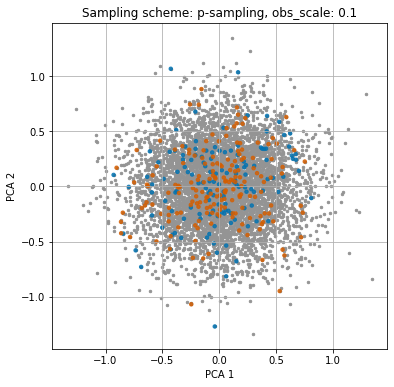

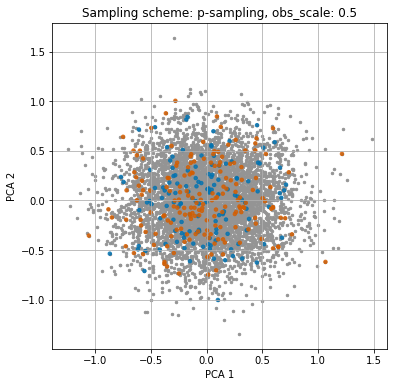

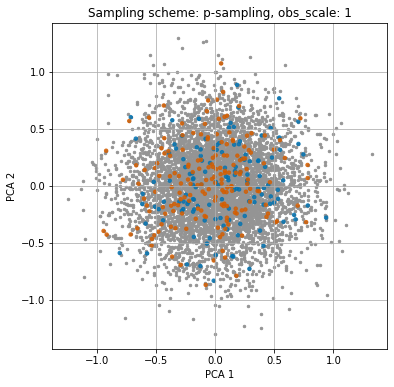

In [66]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

for key, vp_dict in store_params.items():
    # Do PCA on the mean embedding vectors
    pca = PCA(n_components=2)
    embed_vectors = vp_dict['omega_loc'].t().detach().numpy()
    embed_pca = pca.fit_transform(embed_vectors)
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('PCA 1', fontsize=10)
    ax.set_ylabel('PCA 2', fontsize=10)
    ax.set_title('Sampling scheme: {}, obs_scale: {}'.format(sample_args_dict['sample_str'], key),
                 fontsize=12)
    
    ax.scatter(embed_pca[:, 0], embed_pca[:, 1], c='#949494', alpha = 1, s=6)
    
    colors = [0 for i in range(len(data.nodes_with_gt))]
    for i in range(len(data.nodes_with_gt)):
        ind = data.nodes_with_gt[i]
        if data.gt.numpy()[ind] == 1:
            colors[i] = '#0173B2'
        else:
            colors[i] = '#D55E00'
    
    ax.scatter(embed_pca[data.nodes_with_gt, 0], embed_pca[data.nodes_with_gt, 1], c=colors, alpha=0.8, s=12)
    
    ax.grid()
    plt.show()
    fig.savefig('img/embed_pca_sampling_{}_obs_scale_{}.png'.format(
              sample_args_dict['sample_str'], key), bbox_inches='tight')

(talk about PCA plots)

# Model 2.5: Removing the non-negative definiteness assumption on $\mathrm{logit}(a_{ij})$ #

In the previous model, we tried to learn embedding vectors $\omega_i$ such that $\mathrm{logit}(a_{ij}) \approx \langle \omega_i, \omega_j \rangle$ - this forces this matrix to be non-negative definite. To see how this is an implicit constraint on the behavior of users, consider a more simplisitic model where user $i$ gives rating $j$ either a ratings of $+1$ and $-1$, doing the latter with probability $p_{e_i, e_j}$. With the above assumption, this effectively boils down to a requirement that the matrix

$$ \begin{pmatrix} p_{00} & p_{01} \\ p_{10} & p_{11} \end{pmatrix} $$

is non-negative definite. This is equivalent to requiring that $p_{00} p_{11} \geq p_{01} p_{10}$ - this places some constraint on the behavior of trustworthy and non-trustworthy users. We therefore investigate what happens if we allow for some degree of flexibility, by instead setting 

$$ p\big( \{a_{ij} \,:\, i \neq j \} \,|\, \omega_1, \ldots, \omega_N \big)  = \prod_{i \neq j} \mathrm{Normal}\big( \mathrm{logit}(a_{ij}) \,\big|\, \langle \omega_i, B \omega_j \rangle, \tau_0^2 \big) $$

in the likelihood, where $B = \mathrm{diag}\big( I_{d/2}, - I_{d/2} \big)$ - i.e, we allow for the logit ratings matrix to have negative eigenvalues.

## Fitting the model ##

To avoid...

In [13]:
# fit the damn model

## Criticism of Model 2.5 ##

# Conclusion #

Although in the above we've only iterated through a few steps of Box's loop, I want to give a few more examples of how one could expand on the above model:

* Using a more flexible classifier on the embedding vectors (e.g a small neural network).
* Incorporating other covariate information (e.g some of the summary statistics of the rating time distributions) when forming the embeddings/as part of the logistic regression step.
* Handling possible asymmetry in ratings by assigning each user an embedding $\omega_i = (\omega_i^{(out)}, \omega_i^{(in)})$ and then trying to create an approximation $\mathrm{logit}(a_{ij}) \approx \langle \omega_i^{(out)}, \omega_j^{(in)} \rangle$.
* Investigate choosing a different 'link function' to convert the ratings to a continuous spectrum.

Moreover, it would be desirable to have an embedding model which updates as new ratings come in, although this would be substanatially more complicated.

# References

[1] - Veitch, Victor & Austern, Morgane & Zhou, Wenda & Blei, David & Orbanz, Peter. (2019). "Empirical Risk Minimization and Stochastic Gradient Descent for Relational Data". 22nd International Conference on Artificial Intelligence and Statistics.

[2] - V. Veitch and D. M. Roy. 2016. “Sampling and Estimation for (Sparse) Exchangeable Graphs”. arXiv: 1611.00843.

[3] - A. Grover, J. Leskovec. 2016. "node2vec: Scalable Feature Learning for Networks". ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD).